# Linear Elasticity

This example can be found in Section 5.2 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

### Generic functions and imports

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from src.material_model import LinearElasticity as LE

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

save_figures = False

In [2]:
def add_labels(graph_title, x_label, y_label):
    """
    Add labels to graphs
    """
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Noisy experimental observations

We have a series of experimental observations of a material specimen undergoing uniaxial tension and the observations are contaminated by a small amount of noise. Note that only the stress measurement is contaminated by noise. The observations are generated numerically so that they deviate from the *true* constitutive model. The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

$$\Omega = \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(0, 0.01^2)$$

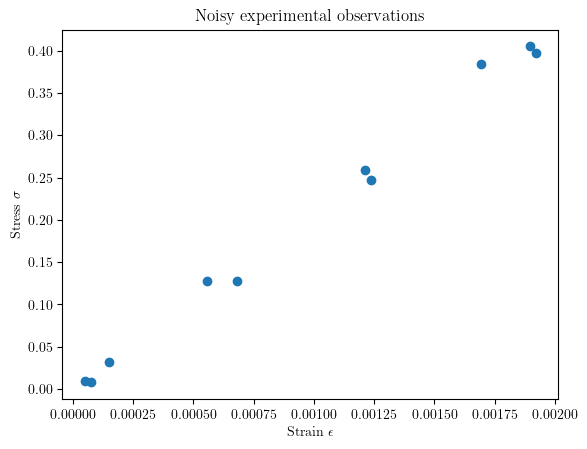

In [3]:
E = 210           # Young's modulus (GPa)
s_noise = 0.01    # Noise in the stress measurement (GPa)
n_observations = 10

model = LE(E, s_noise)
strain = np.linspace(0, 2.5E-3, 100)

strain_data, stress_data = model.generate_synthetic_data(strain, n_observations, seed=12)
plt.scatter(strain_data, stress_data);
add_labels("Noisy experimental observations", "Strain $\epsilon$", "Stress $\sigma$")

## Constitutive model and *true* material parameters

It is assumed that the behaviour of the material specimen can be accurately described by a linear elastic law that is defined by a single parameter: Young's modulus $E$. The stress-strain response of the linear elastic model during uniaxial tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon$$

where $\sigma$ denotes the stress, $\epsilon$ the strain, $\textbf{x}$ the material parameter vector (here $\textbf{x} = E$) and $E$ the Young's modulus. The *true* value of $E$ that we are attempting to identify (infer) from the experimental observations is:

$$E = 210 \; \textrm{GPa}$$

The *true* stress-strain response and the noisy experimental observations are illustrated in the following figure.

In [4]:
def material_model(E, epsilon):
    """
    Calculate stress as a function of strain
    """
    return E * epsilon

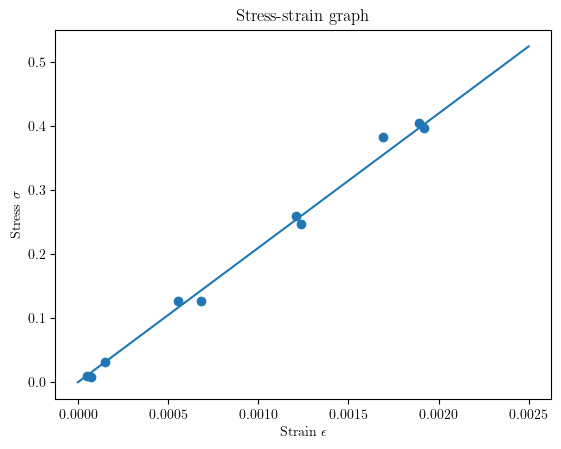

In [5]:
model.stress_strain_response(strain)
plt.scatter(strain_data, stress_data);

## Bayesian Inference

We have some noisy experimental data from a uniaxial tensile test of a material specimen. Using our expert judgement we have hypothesised that the material response can be described by a linear-elastic material law. We now wish to identify (infer) the model parameters from the experimental observations. 

The most commonly used approach to identify model parameters is to formulate an error function that measures the difference between the model response and the experimental data. The error function is then minimised with respect to the model parameters in order to determine the most suitable values (linear regression etc). This approach provides a deterministic estimate of model parameters, and is unable to account for the unavoidable uncertainties associated with determining parameters from noisy experimental data.

Bayesian inference provides...

$$\pi(\textbf{x}|\textbf{y}) = \frac{\pi(\textbf{x})\pi(\textbf{y}|\textbf{x})}{\pi(\textbf{y})}$$

Where $\textbf{x}$ denotes a random vector with $n_p$ unknown parameters and $\textbf{y}$ denotes a random vector with $n_m$ measurements.

## Statistical generating model

We define a statistical model that represents the data-generating process (i.e. a model of our experimental data).

$$\textbf{Y} = \textbf{f}(\textbf{X}) + \Omega$$

where $\textbf{Y}$ denotes a vector of the experimental observations with $n_m$ data points, $\textbf{X}$ denotes the unknown material parameters with $n_p$ unknown parameters, and $\Omega$ is the noise in the experimental observations. $\textbf{f}(\textbf{X})$ denotes the material model and is a function of the unknown material parameters $\textbf{X}$ (model parameters).

## Likelihood $\pi(\textbf{y}|\textbf{x})$

The PDF of the observed data $\textbf{y}$. To construct the likelihood function, a noise model has to be formulated and a noise distribution ($\pi_{noise}$) has to be determined. We assume that the noise distribution is known (including its parameters). The additive noise model can be written as follows:

$$\textbf{y} = \textbf{f}(\textbf{x}) + \Omega$$

Where $\textbf{x}$ denotes the vector with the unknown material parameters, $\textbf{y}$ the vector with the measured data and $\Omega$ is the noise vector. $\textbf{f}$ denotes the material description and is a function of the unknown material parameters ($\textbf{x}$).

$$\pi(\textbf{y}|\textbf{x}) = \pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x}))$$

The only unknown material parameter in the linear elastic model is the Young's modulus ($E$). The additive noise measurement for a single stress measurement can be written as follows:

$$Y = E\epsilon + \Omega$$

Where $Y$ denotes the measured stress and $\Omega$ denotes the random variable representing the noise in the stress measurement. We consider the noise distribution to be normal (Gaussian) and hence, it can be written as:

$$\pi_{noise}(\omega) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{\omega}{s^2_{noise}}}\right)$$

## Prior distribution $\pi(E)$

The probability density function (PDF) that contains one's prior belief

We use a prior in the form of a modified normal distribution:

$$\pi(E) \propto exp\left(-\frac{(E - \overline{E})^2}{2s^2_E}\right) \quad \text{if}\; E \geqslant 0$$

In [6]:
def calculate_prior(E, mean, std_dev):
    return np.exp(-((E - mean)**2 / (2 * std_dev**2)))   

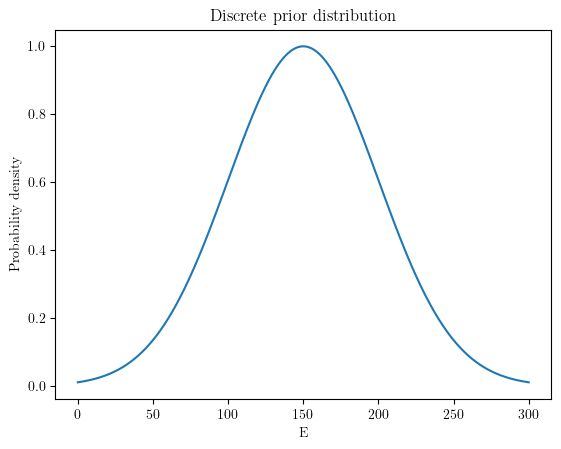

In [7]:
mean = 150.00  # GPa
std_dev = 50.00  # GPa
E_vector = np.linspace(0, 300.00, 10000)

prior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    prior = calculate_prior(E, mean, std_dev)
    prior_list.append(prior)

plt.plot(E_vector, prior_list)
add_labels("Discrete prior distribution", "E", "Probability density")

0.007978845608028654


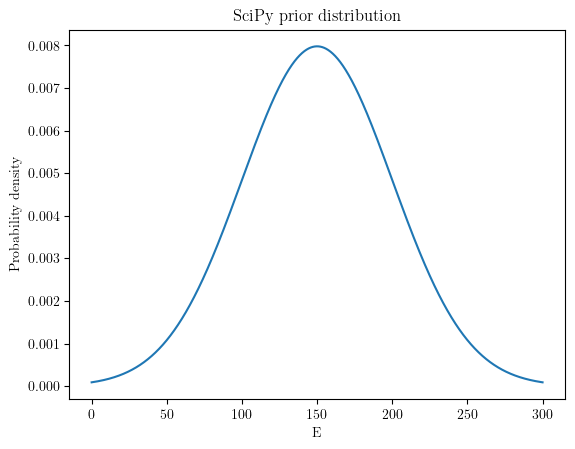

In [18]:
prior_scipy = scipy.stats.norm.pdf(E_vector, mean, std_dev)
plt.plot(E_vector, prior_scipy)
add_labels("SciPy prior distribution", "E", "Probability density")

## Posterior distribution $\pi(E|y)$

The PDF of the unknown parameters $\textbf{x}$, given the observations $\textbf{y}$

The posterior distribution for a single stress measurement reads:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi(\textbf{y}|\textbf{x})$$

$$\pi(E|y) \propto exp\left(-\left[\frac{(E - \overline{E})^2}{2s^2_E} + \frac{(y-E\epsilon)^2} {2s^2_{noise}}\right]\right) \quad \text{if}\; E \geqslant 0$$

Since the data $y$ is already measured, the denominator in Bayes' Theorem $\pi(y)$ is a positive constant number $C$. This constant number can be regarded as a normalisation factor that ensures that the integral of the posterior $\pi(E|y)$ over $E$ equals 1:

$$\pi(E|y) = \frac{1}{C}\pi(E)\pi(y|E)$$

In [9]:
def calculate_posterior(E, mean, std_dev, stress, strain, std_dev_noise):
    tmp_1 = (E - mean)**2 / (2 * std_dev**2)
    tmp_2 = 0
    for i in range(len(stress)):
        tmp_2 += (stress[i] - E*strain[i])**2 
    tmp_2 /= (2 * std_dev_noise**2)
    posterior = np.exp(-(tmp_1 + tmp_2))
    return posterior    

## Stress-strain graph - one measurement

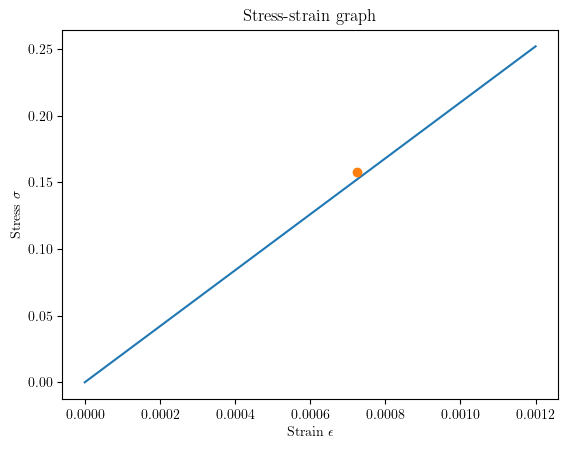

In [10]:
E_true = 210
strain = np.linspace(0, 1.2E-3)
stress = E_true * strain

stress_measured = [0.1576]
strain_measured = [7.25E-4]

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

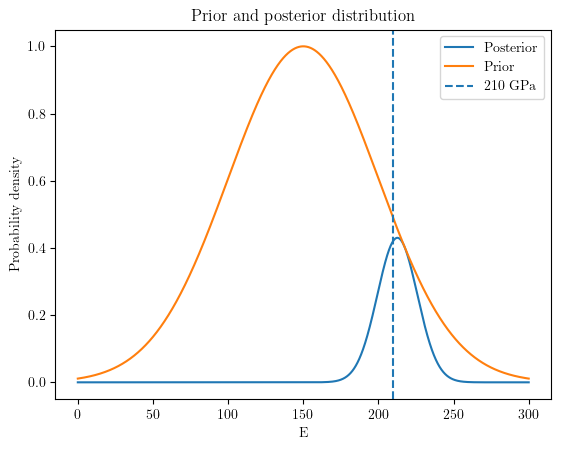

In [11]:
posterior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    posterior = calculate_posterior(E, mean, std_dev, stress_measured, strain_measured, s_noise)
    posterior_list.append(posterior)

plt.plot(E_vector, posterior_list, label='Posterior')
plt.plot(E_vector, prior_list, label='Prior')
plt.axvline(x=E_true, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution", "E", "Probability density")

In [12]:
posterior_integral = np.trapz(posterior_list, E_vector)
prior_integral = np.trapz(prior_list, E_vector)
print('Integral of the posterior =', posterior_integral)
print('Integral of the prior =', prior_integral)

Integral of the posterior = 14.334268470159387
Integral of the prior = 124.99304437415378


### Normalise

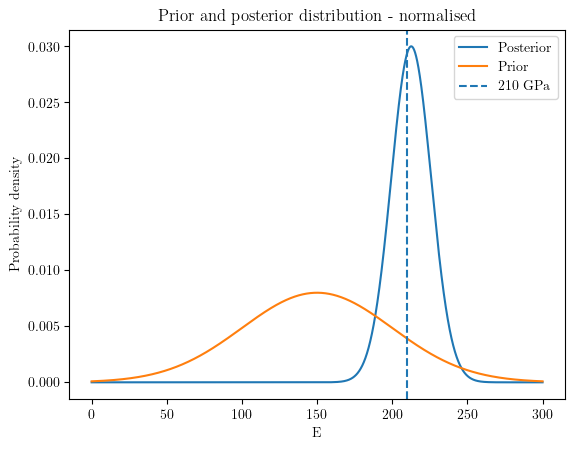

In [13]:
plt.plot(E_vector, np.asarray(posterior_list) * (1 / posterior_integral), label='Posterior')
plt.plot(E_vector, np.array(prior_list) * (1 / prior_integral), label='Prior')
plt.axvline(x=E_true, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution - normalised", "E", "Probability density")

## Stress-strain graph - ten measurements

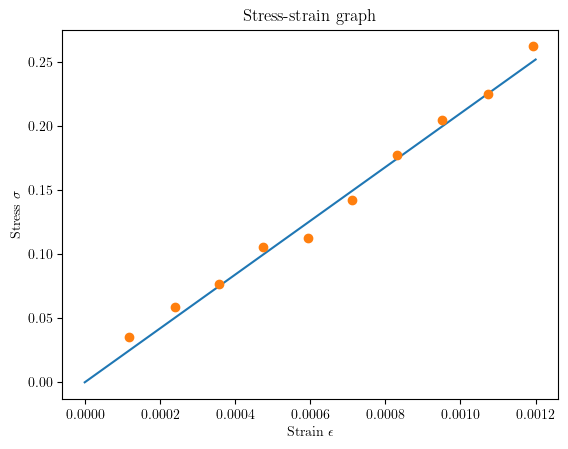

In [14]:
stress_measured = [0.0357, 0.0585, 0.0767, 0.1059, 0.1123, 
                   0.1423, 0.1773, 0.2046, 0.2251, 0.2623]
strain_measured = [0.1168E-3, 0.2400E-3, 0.3568E-3, 0.4747E-3, 0.5935E-3, 
                   0.7124E-3, 0.8303E-3, 0.9503E-3, 1.0724E-3, 1.1924E-3]

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

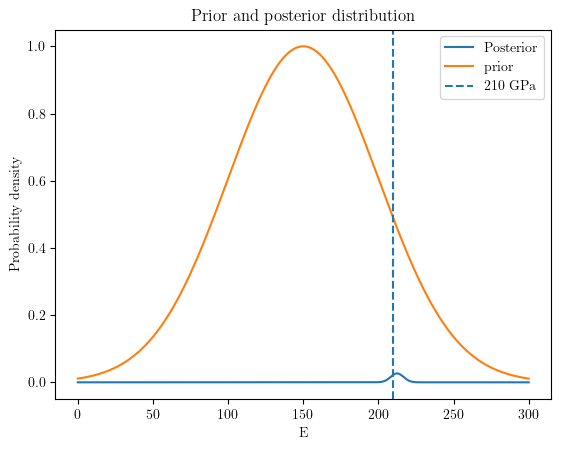

In [15]:
posterior_list = []

for i in range(len(E_vector)):
    E = E_vector[i]
    posterior = calculate_posterior(E, mean, std_dev, stress_measured, strain_measured, s_noise)
    posterior_list.append(posterior)

plt.plot(E_vector, posterior_list, label='Posterior')
plt.plot(E_vector, prior_list, label='prior')
plt.axvline(x=E_true, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution", "E", "Probability density")

In [16]:
posterior_integral = np.trapz(posterior_list, E_vector)
print('Integral of the posterior =', posterior_integral)

Integral of the posterior = 0.28455275971026794


### Normalise

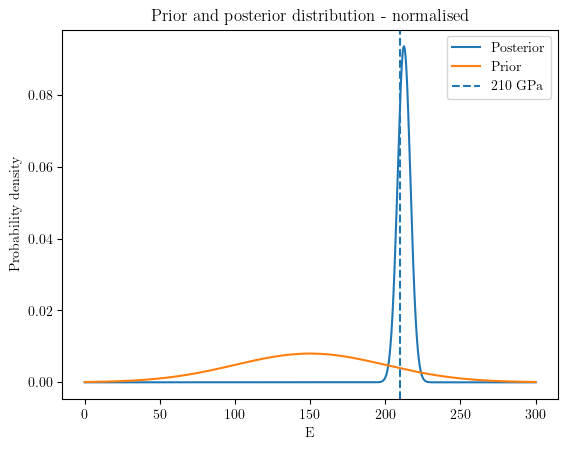

In [17]:
plt.plot(E_vector, np.asarray(posterior_list) * (1 / posterior_integral), label='Posterior')
plt.plot(E_vector, np.array(prior_list) * (1 / prior_integral), label='Prior')
plt.axvline(x=E_true, label='210 GPa', linestyle='--')
plt.legend()
add_labels("Prior and posterior distribution - normalised", "E", "Probability density")